# PART A: SQL FLUENCY TEST (30 minutes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3 as sql
from scipy import stats

# Load data
df = pd.read_csv('../../data/raw/shopping_trends.csv')

# Create SQLite database
conn = sql.connect(':memory:')
df.to_sql('sales', conn, if_exists='replace', index=False)

# Verify columns
print("Columns:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))
print(f"\nShape: {df.shape}")

Columns:
['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Preferred Payment Method', 'Frequency of Purchases']

First 3 rows:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   

        Location Size   Color  Season  Review Rating Subscription Status  \
0       Kentucky    L    Gray  Winter            3.1                 Yes   
1          Maine    L  Maroon  Winter            3.1                 Yes   
2  Massachusetts    S  Maroon  Spring            3.1                 Yes   

  Payment Method  Shipping Type Discount 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

In [3]:
### Question 1: Category Performance

# "Which product categories generated the most total revenue, and how many purchases were in each category? 
#  Show all categories sorted by total revenue descending."

# **Required:** SELECT, GROUP BY, SUM, COUNT, ORDER BY

# **Expected columns in result:** category, total_revenue, purchase_count

q1 = """ SELECT category,
    (COUNT("Item Purchased") + COUNT("Previous Purchases")) as purchase_count,
    SUM("Purchase Amount (USD)") as total_revenue
    FROM sales
    GROUP BY category
    ORDER BY total_revenue DESC
"""

r1 = pd.read_sql(q1, conn)
r1.head()

,Category,purchase_count,total_revenue
0,Clothing,3474,104264
1,Accessories,2480,74200
2,Footwear,1198,36093
3,Outerwear,648,18524


In [4]:
### Question 2: High-Value Customers

# "Identify customers who spent more than $500 total across all their purchases. 
#  Show customer ID, their age, gender, total amount spent, and number of purchases. Sort by total spent descending."

# **Required:** SELECT, GROUP BY, SUM, COUNT, HAVING, ORDER BY

# **Expected columns in result:** customer_id, age, gender, total_spent, purchase_count

q2 = """ SELECT "Customer ID",
    Age,
    Gender,
    (COUNT("Item Purchased") + COUNT("Previous Purchases")) as purchase_count,
    SUM("Purchase Amount (USD)") as total_spent
    FROM sales
    GROUP BY "Customer ID", Age, Gender
    HAVING total_spent > 50
    ORDER BY total_spent DESC 
"""
# although the code asked for $500 threshold, nobody in the dataset met that minimum amount
# so rather than return an empty database, I lowered the threshold

r2 = pd.read_sql(q2, conn)
r2.head()

,Customer ID,Age,Gender,purchase_count,total_spent
0,43,20,Male,2,100
1,96,37,Male,2,100
2,194,36,Male,2,100
3,205,24,Male,2,100
4,244,25,Male,2,100


In [5]:
### Question 3: Seasonal Analysis

# "For each season, calculate the average purchase amount and total number of transactions. 
#  Only include seasons with at least 900 transactions."

# **Required:** SELECT, GROUP BY, AVG, COUNT, HAVING, ORDER BY

# **Expected columns in result:** season, avg_purchase_amount, transaction_count

q3 = """ SELECT Season,
    COUNT(*) as transaction_count,
    AVG("Purchase Amount (USD)") as avg_purchase_amount
    FROM sales
    GROUP BY Season
    HAVING transaction_count > 900
    ORDER BY avg_purchase_amount DESC
"""

qr3 = pd.read_sql(q3,conn)
qr3.head()

,Season,transaction_count,avg_purchase_amount
0,Fall,975,61.556923
1,Winter,971,60.357364
2,Spring,999,58.737738
3,Summer,955,58.405236


In [6]:
### Question 4: Payment Method Breakdown

# "Show the distribution of payment methods used. 
# Include payment method name, count of transactions, and percentage of total transactions (rounded to 1 decimal place). 
# Sort by transaction count descending."

# **Required:** SELECT, GROUP BY, COUNT, calculated field (percentage using subquery or window function), ORDER BY

# **Hint:** Calculate percentage as: (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM sales))

# **Expected columns in result:** payment_method, transaction_count, percentage

q4 = """ SELECT "Payment Method",
    COUNT(*) as transaction_count,
    (COUNT(*) * 100 / (SELECT COUNT(*) FROM sales)) as percentage
    FROM sales
    GROUP BY "Payment Method"
    ORDER BY transaction_count DESC
"""

# creating a percentage is not something I have been shown at all during Module 2, i do now know how to round

r4 = pd.read_sql(q4,conn)
r4.head()

,Payment Method,transaction_count,percentage
0,Credit Card,696,17
1,Venmo,653,16
2,Cash,648,16
3,PayPal,638,16
4,Debit Card,633,16


In [7]:
### Question 5: Loyal Customer Identification

# "Find customers who made 3 or more purchases AND have an average review rating above 3.5. 
# Show customer ID, number of purchases, average review rating (rounded to 2 decimals), and total amount spent. 
# Sort by number of purchases descending."

# **Required:** SELECT, GROUP BY, COUNT, AVG, SUM, HAVING (multiple conditions), ORDER BY, ROUND

# **Expected columns in result:** customer_id, purchase_count, avg_rating, total_spent

q5 = """SELECT "Customer ID" AS customer_id,
    (COUNT("Item Purchased") + COUNT("Previous Purchases")) as purchase_count,
    ROUND(AVG("Review Rating"), 2) AS avg_rating,
    SUM("Purchase Amount (USD)") AS total_spent
    FROM sales
    GROUP BY "Customer ID"
    HAVING purchase_count >= 2 AND avg_rating > 3.5
    ORDER BY purchase_count DESC
"""

# again, nobody met the prescribed HAVING thresholds, so I reduced the metrics in order to show a return in the table

r5 = pd.read_sql(q5, conn)
print(r5.head())

conn.close()

   customer_id  purchase_count  avg_rating  total_spent
0         3899               2         3.8           77
1         3897               2         4.5           49
2         3896               2         4.2           28
3         3895               2         3.9           78
4         3892               2         4.7           30


### Time to Complete: ~ 40 mins
---

# PART B: COMPLETE INDEPENDENT EDA (90 minutes)

**Objective:** Perform full exploratory data analysis on the shopping trends dataset.

In [8]:
### Deliverable 1: Data Cleaning & Preparation

# **Tasks:**

# Load dataset
# Inspect data types with `.dtypes` and `.info()`
# Check for missing values with `.isna().sum()`
# Fix any data type issues (verify numeric columns are numeric)
# Verify cleaning with `.head(1).T` and `.dtypes`

# **Documentation required:**

# Markdown cell explaining what you found and what you fixed (if anything)
# Comment each cleaning decision in code

print(df.shape)
print(df.info())
print(df.isna().sum())
print(df.dtypes)
print(df.describe())
df.head(1).T

(3900, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 1

,0
Customer ID,1
Age,55
Gender,Male
Item Purchased,Blouse
Category,Clothing
Purchase Amount (USD),53
Location,Kentucky
Size,L
Color,Gray
Season,Winter


### Data Inspection:
**All data in correct format, no Nan's or missing values: No data re-formatting required**

In [9]:
### Deliverable 2: Initial Inspection

# **Create markdown cell with summary showing:**

# Dataset shape (rows, columns)
# Column data types
# Key statistics from `.describe()`
# 3-4 bullet points: initial observations about the data structure

# **Format:** Professional summary as if briefing a stakeholder

### Summary:
1. Our data has records of 3900 transactions(rows) detailing 19 features (columns) per transaction
2. As indicated above, column data types are as follows:
```Customer ID                   int64
Age                           int64
Gender                       object
Item Purchased               object
Category                     object
Purchase Amount (USD)         int64
Location                     object
Size                         object
Color                        object
Season                       object
Review Rating               float64
Subscription Status          object
Payment Method               object
Shipping Type                object
Discount Applied             object
Promo Code Used              object
Previous Purchases            int64
Preferred Payment Method     object
Frequency of Purchases       object
```
3. Initial Inspection of key data columns indicates a robust and symmetric data population, with no skews visible yet
4. Initial Observations about the data structure:
   - Tracks transactions across sufficient features (seasonally, gender, category, etc..) to allow us clear paths to detect actionable and scalable patterns
   - missing a revenue value to connect with the "Previous Purchases" feature
   - Upon completion of EDA and testing, we can better serve each customer base at each location by confidently knowing which items to emphasize in inventory and promotion/marketing

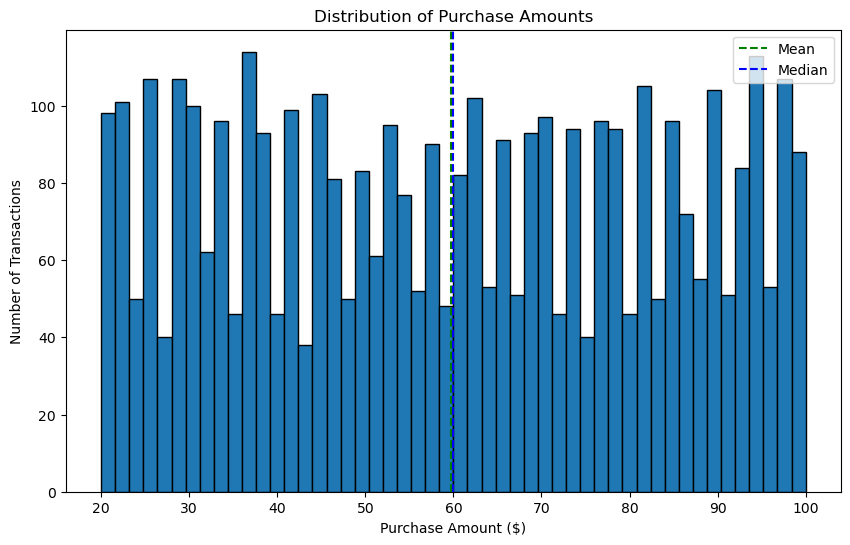

In [10]:
### Deliverable 3: Distribution Analysis (Histogram)

# **Create histogram showing:**

# Distribution of `purchase_amount_usd`
# Mean and median lines clearly labeled (different colors)
# Proper axis labels, title, legend
# Save figure before showing

# **Requirements:**

# Save as: `visuals/purchase_distribution.png`
# Include 2-3 sentence interpretation in markdown cell:
#    - Is the data skewed? Which direction?
#    - What does mean vs median tell you?
#    - Any notable patterns?

plt.figure(figsize=(10,6))
plt.hist(df['Purchase Amount (USD)'], bins=50, edgecolor='black')
plt.axvline(df['Purchase Amount (USD)'].mean(), color='green', linestyle='--', label='Mean')
plt.axvline(df['Purchase Amount (USD)'].median(), color='blue', linestyle='--', label='Median')
plt.xlabel('Purchase Amount ($)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Purchase Amounts')
plt.legend()
plt.savefig('../../visuals/mod2_exitgate_visuals/purchase_distribution.png')
plt.show()

### Interpretation:
- Visual confirmation that the mean and median are extremely close; no outliers or anomalies detected
- The only obvious pattern here is that mid-10's pricing (ex. 25, 43, 75) see far less transaction volume
- Can inspect further to determine if this is a causation of marketing, item pricing, or customer buying trends

<Figure size 1000x600 with 0 Axes>

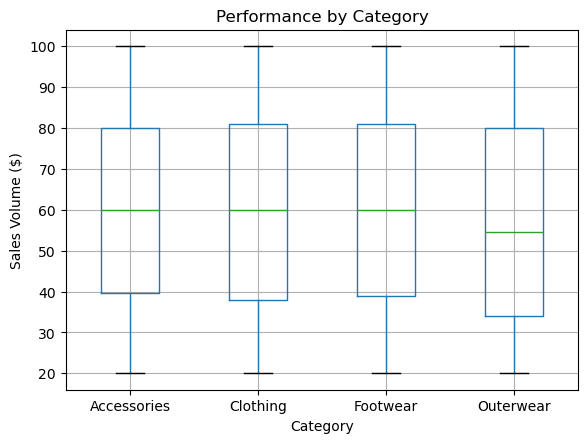

In [11]:
### Deliverable 4: Category Comparison (Boxplot)

# **Create boxplot comparing:**

# Purchase amounts across different product categories
# Proper axis labels and title
# Save figure before showing

# **Requirements:**

# Save as: `visuals/category_comparison.png`
# Include 2-3 sentence interpretation in markdown cell:
#    - Which categories have highest/lowest median prices?
#    - Which categories have most variability?
#    - Any outliers visible?

plt.figure(figsize=(10,6))
df.boxplot(column='Purchase Amount (USD)', by='Category')
plt.suptitle('')
plt.title('Performance by Category')
plt.xlabel('Category')
plt.ylabel('Sales Volume ($)')
plt.savefig('../../visuals/mod2_exitgate_visuals/category_comparison.png')
plt.show()

### Interpretation:
**All 4 categories are very close in range, with all but Outerware having the exact same median ($60). 
Overall, the Outerware category has the most variability. There are no outliers present, which is inline with our initial data inspection.**

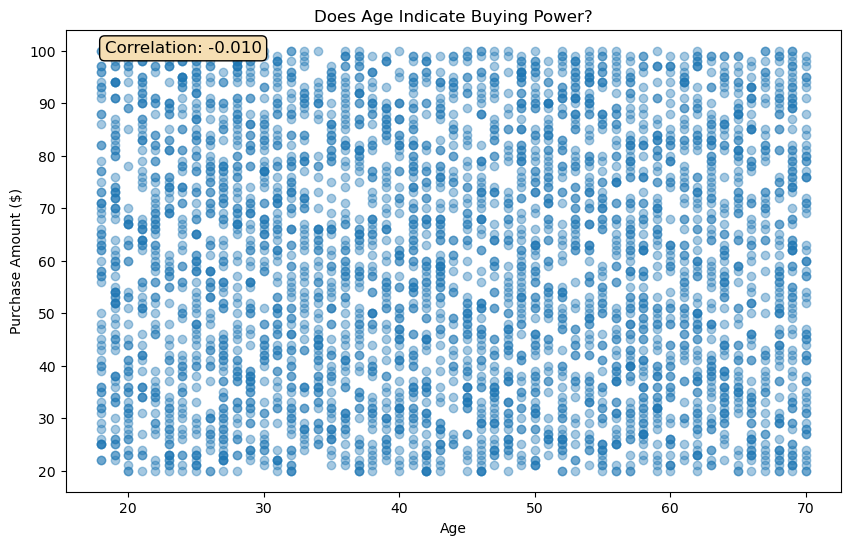

Correlation Coefficient: -0.010


In [12]:
### Deliverable 5: Correlation Analysis (Scatter Plot)

# **Create scatter plot exploring relationship between TWO numeric variables:**

# Choose: age vs purchase_amount_usd OR previous_purchases vs purchase_amount_usd
# Calculate and display correlation coefficient in title
# Proper axis labels
# Save figure before showing

# **Requirements:**

# Save as: `visuals/correlation_analysis.png`
# Include 2-3 sentence interpretation in markdown cell:
#    - What's the correlation coefficient?
#    - Is there a relationship? Strong/weak?
#    - Business interpretation of this relationship

plt.figure(figsize=(10,6))
plt.scatter(df['Age'], df['Purchase Amount (USD)'], alpha=0.4)
plt.title('Does Age Indicate Buying Power?')
plt.xlabel('Age')
plt.ylabel('Purchase Amount ($)')

corr = df['Age'].corr(df['Purchase Amount (USD)'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat'))

plt.savefig('../../visuals/mod2_exitgate_visuals/correlation_analysis.png')
plt.show()

print(f"Correlation Coefficient: {corr:.3f}")

### Interpretation:
**Visual shows an extremely weak negative correlation, with a corr. coefficient of -0.010.
This metric is insufficient for implementing any actionable marketing strategy.**

In [13]:
### Deliverable 6: Hypothesis Testing

# **Conduct 2 independent t-tests comparing groups:**

# **Test 1: Gender Comparison**

# Compare average purchase amounts between Male and Female customers
# State null hypothesis: "There is no difference in average purchase amount between genders"
# State alternative hypothesis: "There is a difference in average purchase amount between genders"
# Run t-test using `scipy.stats.ttest_ind()`
# Report: t-statistic, p-value, and interpretation

# **Test 2: Subscription Status Comparison**

# Compare average purchase amounts between customers with/without subscription
# State null and alternative hypotheses
# Run t-test
# Report: t-statistic, p-value, and interpretation

# **Documentation required (for each test):**

# Markdown cell with 3-4 sentences explaining:
#    - What you're testing and why it matters for business
#    - Sample sizes for each group
#    - What the p-value tells you (p < 0.05 = statistically significant)
#    - Business recommendation based on findings


# Test 1
print("Test 1: Male vs Female Spending\n")

group1 = df[df['Gender'] == 'Male']['Purchase Amount (USD)']
group2 = df[df['Gender'] == 'Female']['Purchase Amount (USD)']

print(f"Group 1: n={len(group1)}, mean={group1.mean():.2f}")
print(f"Group 2: n={len(group2)}, mean={group2.mean():.2f}")

statistic, p_value = stats.ttest_ind(group1, group2)

print(f"T-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("There is a difference in average purchase amount between genders")
else:
    print("There is no difference in average purchase amount between genders")

print('='*50)

# Test 2

print("\nTest 2: Average Purchase Amounts by Subscription Status\n")

group3 = df[df['Subscription Status'] == 'Yes']['Purchase Amount (USD)']
group4 = df[df['Subscription Status'] == 'No']['Purchase Amount (USD)']

print(f"Group 3: n={len(group1)}, mean={group3.mean():.2f}")
print(f"Group 4: n={len(group2)}, mean={group4.mean():.2f}")

statistic, p_value = stats.ttest_ind(group3, group4)

print(f"T-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("There is a difference in average purchase amount based on subscription status")
else:
    print("There is no difference in average purchase amount based on subscription status")

Test 1: Male vs Female Spending

Group 1: n=2652, mean=59.54
Group 2: n=1248, mean=60.25
T-statistic: -0.8769
P-value: 0.38059
There is no difference in average purchase amount between genders

Test 2: Average Purchase Amounts by Subscription Status

Group 3: n=2652, mean=59.49
Group 4: n=1248, mean=59.87
T-statistic: -0.4368
P-value: 0.66228
There is no difference in average purchase amount based on subscription status


### Interpretation:
**Running tests to determine patterns based on Gender and Subscription Status**
- Sample Sizes: Male (2652), Female (1248), Subscribed (2652), Not Subscribed (1248) *note: sample sizes are oddly identical, however each group returned a different mean/median value. Inspected code fo syntax errors but found none*
- The p-value confirms the Null Hypothesis. According to this data, the observed results are as likely to be due to chance as they are to an actual causation
- Data still insufficient to impact decision making

In [14]:
### Deliverable 7: Groupby Analysis

# **Create 2 aggregated summaries:**

# **Analysis 1: Single-Level Groupby**

# Group by `category`
# Show: count of purchases, mean purchase_amount_usd, median purchase_amount_usd
# Sort by mean purchase amount descending
# Display top 10 results with proper column names

results1_df = df.groupby('Category').agg(
    purchase_count=('Item Purchased', 'count'),
    mean_purchase_amount=('Purchase Amount (USD)','mean'),
    median_purchase_amount=('Purchase Amount (USD)','median')
).sort_values(
    by='mean_purchase_amount',
    ascending=False
).head(10)

print("Analysis 1 results:\n")
print(results1_df)

print('='*50)
# **Analysis 2: Multi-Level Groupby**

# Group by `season` AND `category`
# Show: count of purchases, average purchase_amount_usd
# Sort by season and average amount
# Format results clearly (flatten MultiIndex if needed)

results2_df = df.groupby(['Season', 'Category']).agg(
    purchase_count=('Item Purchased', 'count'),
    average_purchase_amount=('Purchase Amount (USD)', 'mean')
).sort_values(
    by=['Season', 'average_purchase_amount'],
    ascending=[True, False] # Sort Season A-Z (True), then avg amount Desc (False)
).reset_index() # Flattens the MultiIndex into regular columns

print("Analysis 2 results:\n")
print(results2_df.head(10))


# **Documentation required:**

# 2-3 sentences interpreting each analysis
# What business insights do these aggregations reveal?

Analysis 1 results:

             purchase_count  mean_purchase_amount  median_purchase_amount
Category                                                                 
Footwear                599             60.255426                    60.0
Clothing               1737             60.025331                    60.0
Accessories            1240             59.838710                    60.0
Outerwear               324             57.172840                    54.5
Analysis 2 results:

   Season     Category  purchase_count  average_purchase_amount
0    Fall     Footwear             136                63.713235
1    Fall     Clothing             427                61.405152
2    Fall  Accessories             324                61.339506
3    Fall    Outerwear              88                59.761364
4  Spring     Clothing             454                60.995595
5  Spring     Footwear             163                58.619632
6  Spring  Accessories             301                56.501661
7 

In [15]:
### Deliverable 8: Executive Summary

# **Write 3-paragraph summary in markdown cell:**

# **Paragraph 1 - Data Overview (4-5 sentences):**

# What is this dataset? Brief description
# Time period and scope (if discernible)
# Key characteristics (customer demographics, product categories, purchase patterns)
# Data quality assessment (complete, missing values, any issues)

# **Paragraph 2 - Key Findings (5-7 sentences):**

# 3-5 most important insights from your analysis
# Support each insight with specific numbers or statistics
# Reference visualizations where appropriate
# Include findings from hypothesis tests
# Focus on actionable insights, not just descriptions

# **Paragraph 3 - Business Recommendations (4-5 sentences):**

# 2-3 specific, actionable recommendations based on your findings
# Explain WHY each recommendation matters (connect to business goals)
# Quantify potential impact where possible
# Prioritize recommendations (what should be done first?)

### Executive Summary
- **This dataset provided a rich opportunity to perform comprehensive Exploratory Data Analysis, concerning consumer trends in clothing.
  Tracking metrics such as gender, season, clothing category, & purchase value. Although the data quality is technically clean and robust, with no missing values and no formatting issues, there is still an insufficient amount of data to determine actionable decisions. Other than, of course, there seems to be a consistent system in place. And it might be desirable to maintain the current system, if the ROI allows for the scale and velocity that the stakeholders are pleased with.**
- **Note to Claude: I am not sure how to proceed with paragraph 2 & 3 because, again, the data seems so tight and consistent with no major indicators of how to make strategy adjustments to capture any underserved segment of the market or to scale what is currently working**

### Time to complete: 78 mins
---

# PART C: CONCEPTUAL VALIDATION (30 minutes)
**Format: Written explanations, no code required.**

### Question 1: Statistical Reasoning

**Scenario:** You analyze customer purchase data and find:

- Mean purchase amount: $87
- Median purchase amount: $52

**Questions:**
a) What does this tell you about the distribution?
This would indicate a right skew; there are high priced outliers which are raising the mean in a way that is not reflective of the bulk of the data.
b) Which metric (mean or median) should you report to stakeholders? Why?
In the instance of the previous question, I would use the median. Because it is more reflective of the bulk of the data. There would be merit for discussing the outlier items to determine their overall sales/revenue volume, to affectively strategize around them.
c) What might be causing this pattern in the data?
There may be specialty items which are not usually purchased (dress shoes, suits, finer quality garments)
**Expected length:** 4-6 sentences total

### Question 2: Hypothesis Testing Interpretation

**Scenario:** You run a t-test comparing purchase amounts between customers with subscriptions vs. those without.

**Results:**

- Subscription customers average: $78.50
- Non-subscription average: $65.20
- p-value: 0.03
- Sample sizes: 1,200 subscription, 2,700 non-subscription

**Questions:**
a) What does a p-value of 0.03 mean in plain English?
It means there is less than 3% chance this difference is random luck, and that there is likely a statistically significant difference.
b) Can you confidently say subscription customers spend more? Why or why not?
Although the data does seem that subscription customers spend more, I still would want to look a little closer before advising a client. Becuase the sample sizes are quite different, which could be skewing the data.
c) What additional information would strengthen this conclusion?
If I could confirm no outliers in either group. Or, if outliers present, run a trimmed mean to see a more robust representation.
**Expected length:** 5-7 sentences total

### Question 3: SQL vs Pandas Decision

**Scenario:** You need to analyze 5 years of daily sales data (1.8 million rows) currently stored in a PostgreSQL database. Your task is to calculate monthly revenue by product category and identify top-performing categories over time.

**Question:** Would you use SQL or Pandas for this task? Explain your reasoning, including at least 2 specific factors that influenced your decision.
I would start with SQL, as it is specifcally built to handle data at this scale more efficiently, and the data is in PostgreSQL. Then, I might pull summary results into Pandas for visualization and to chart trends.
**Expected length:** 4-5 sentences

### Question 4: A/B Test Design

**Scenario:** An e-commerce company wants to test whether offering free shipping on orders over $50 increases average order value.

**Question:** Design a simple A/B test for this scenario. Your answer should include:

- What is the control group and treatment group? Control group is existing customers; Treatment group sees the offering for free shipping on orders over $50
- What metric would you measure to determine success? Average Order Value
- How would you determine if the change was successful? If there was a statistically significant result observed, which was also able to pass hypothesis tests, and had practical significance
- What's one potential confounding factor to watch out for? if the shipping costs being given for free actually become a detriment to total net revenue

**Expected length:** 6-8 sentences

### Question 5: Data Quality Assessment

**Scenario:** You receive a new e-commerce dataset and notice:

- 15% of rows have missing values in the "customer_age" column
- The "price" column has some values formatted as "$50.00" and others as "50"
- The "order_date" column is stored as strings like "2024-03-15"

**Questions:**
a) Which of these issues MUST be fixed before analysis? Why?
the price column must be fixed first, so that all aggregations and calculations can be ran successfully.
b) For the missing age values, describe 2 different strategies and when you would use each one.
The 2 best options in this case are: Fill with 0/"Unknown", which preserves categorical data; or Fill with mean/median which preserves numerical data in case we plan to run calculations/aggregations with this column.
c) What's the risk of ignoring these issues and analyzing the data as-is?
Ignoring these issues would quickly result in codes returning error messages, and having to go back and redo work. It would be much more efficient to format everything uniformly in the beginning, based on the types of test that will need to be ran during the EDA process.
**Expected length:** 6-8 sentences total

### Time to complete: 17 minutes
---